# Hate Speech on Hit Songs using BERT model

BERT: Bidirectional Encoder Representation from Transformers

Objectives:

1. Masked Language Modeling

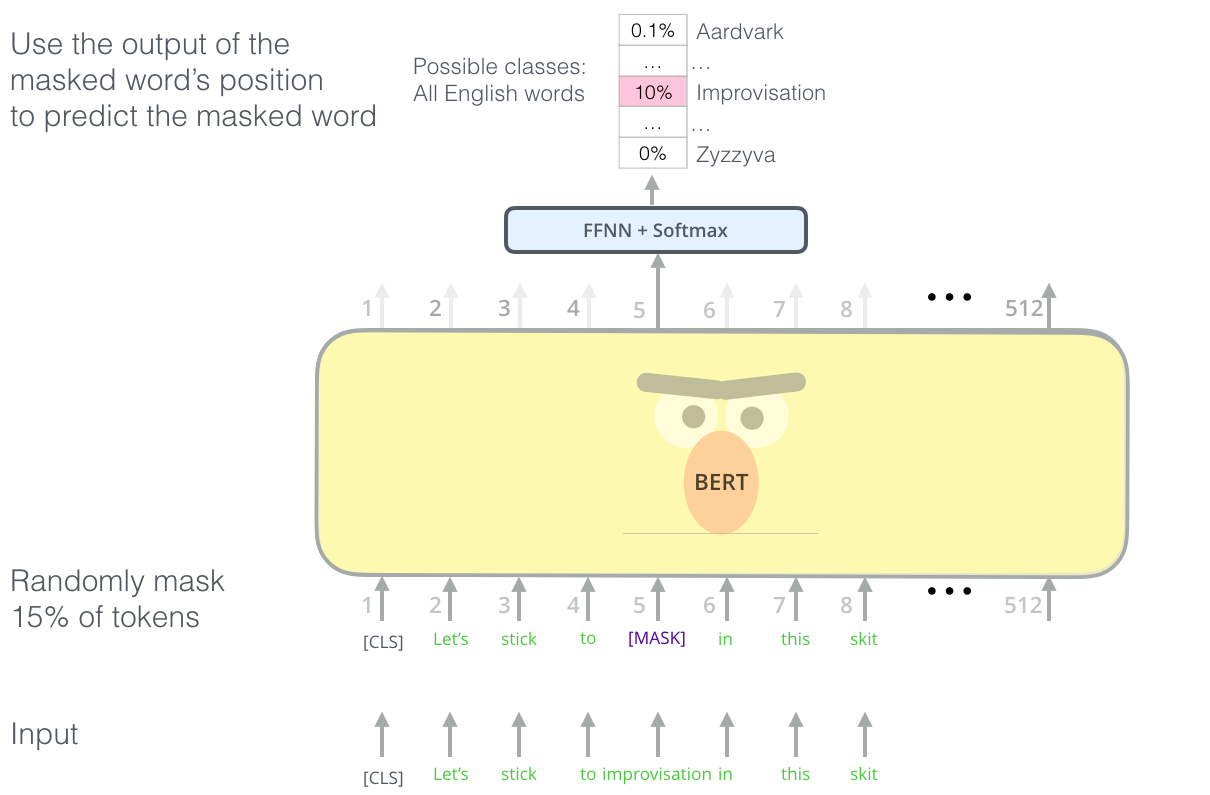

2. Next Sentence Prediction: 

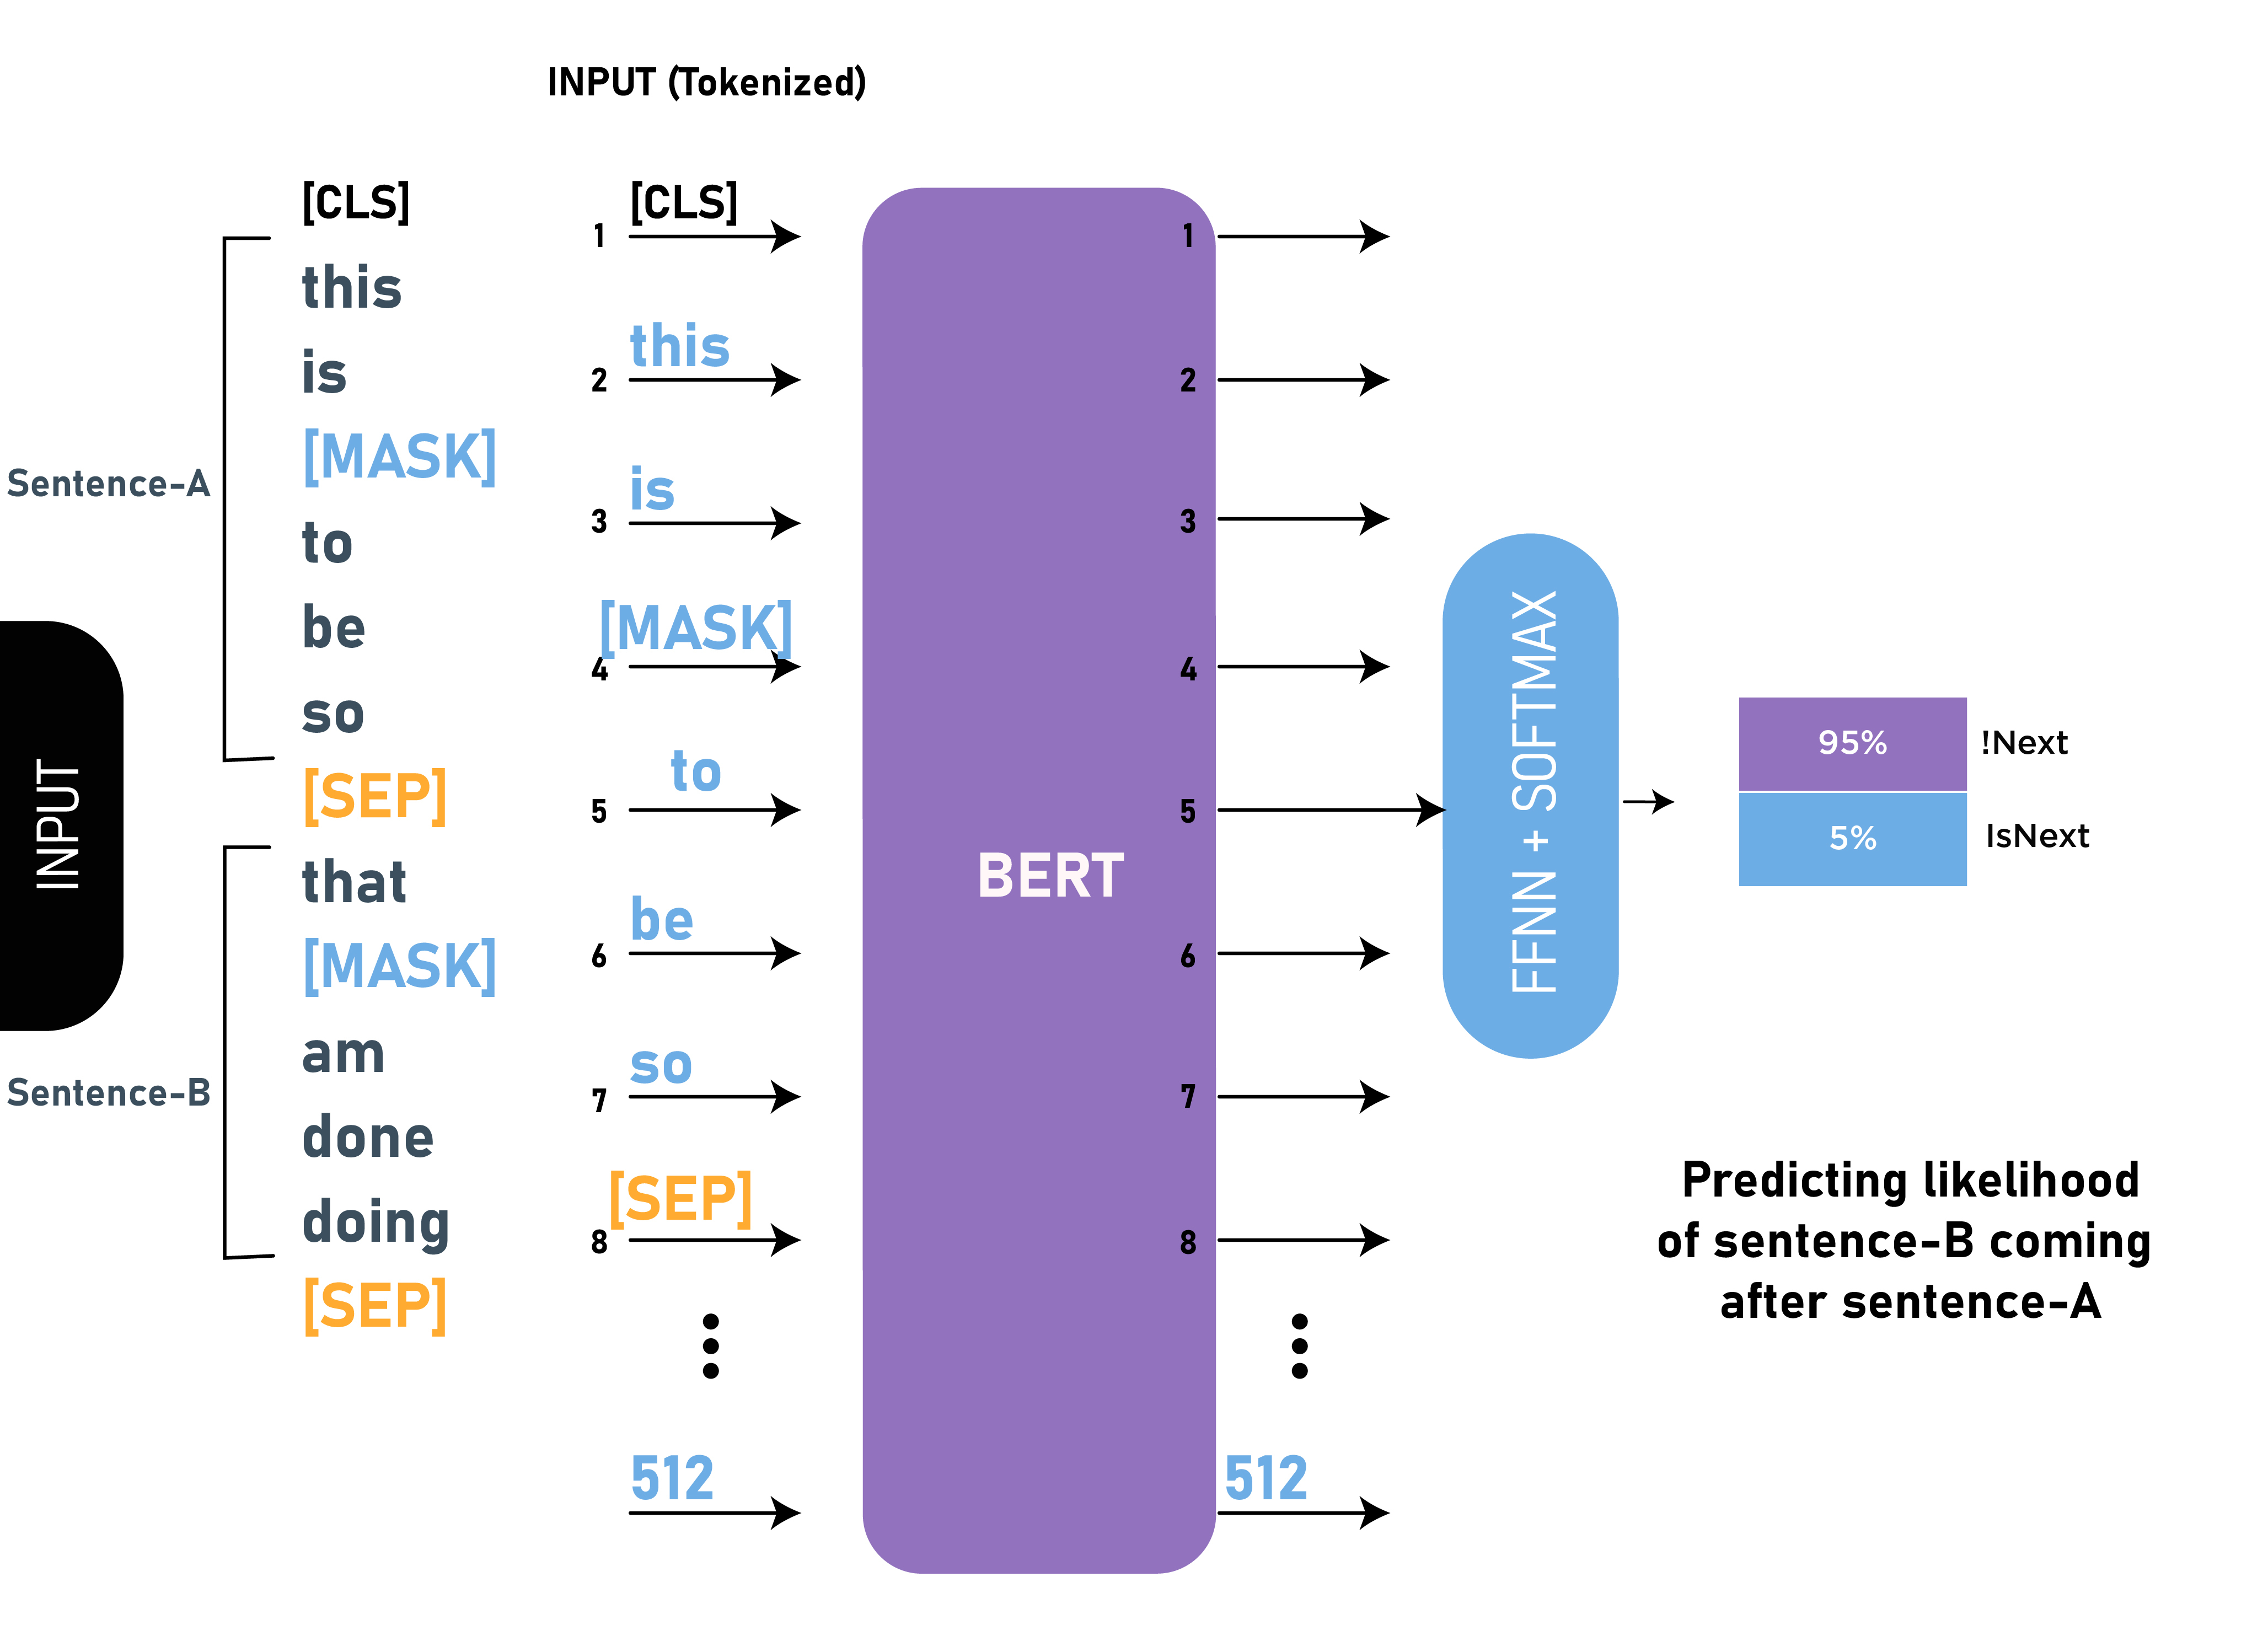

# Objective of our project:

1. Multi-label Hate Speech Classification in songs
2. Hate Speech growth over the years in streaming songs

In [1]:
#importing some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#importing the train dataset
!wget https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
df1 = pd.read_csv('labeled_data.csv')

--2020-12-10 07:46:49--  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546446 (2.4M) [text/plain]
Saving to: ‘labeled_data.csv’

labeled_data.csv    100%[===================>]   2.43M  --.-KB/s    in 0.1s    

2020-12-10 07:46:49 (18.5 MB/s) - ‘labeled_data.csv’ saved [2546446/2546446]



In [3]:
#taking only the required columns after filtering
df1.rename(columns = {'Unnamed: 0':'id'}, inplace = True) 
df1.rename(columns = {'tweet':'text'}, inplace = True) 
df1.rename(columns = {'class':'label'}, inplace = True)
train=df1[['id','text','label']]
print(train.head())

   id                                               text  label
0   0  !!! RT @mayasolovely: As a woman you shouldn't...      2
1   1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2   2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3   3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4   4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1


label 0- Hate Speech
label 1- Offensive Language
label 2- None

In [4]:
#splitting train dataset for training and validation
from sklearn.model_selection import train_test_split
X = train.text.values
y = train.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [5]:
#gpu setup
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
#data cleaning
def text_preprocessing(s):
    s = re.sub(r'(@.*?)[\s]', ' ', s) #removing @mentions
    s = re.sub(r"\n", " ", s) #replacing \n with space
    s = re.sub(r'\s+', ' ', s).strip() #removing trailing whitespace
    return s

#preprocessing text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

In [ ]:
#installing transformers
!pip install transformers==2.8.0

# Word Tokenizer

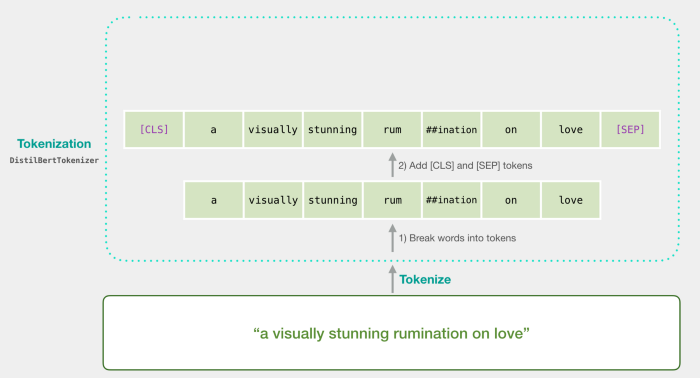

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

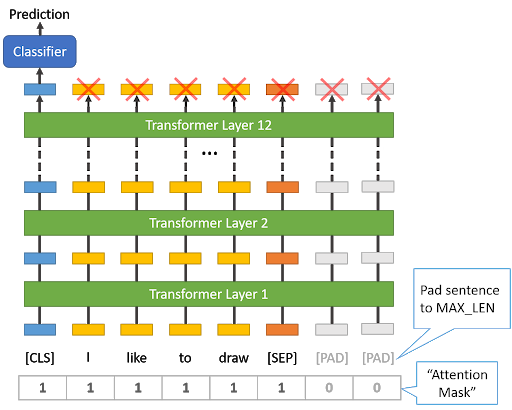

In [ ]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),
            add_special_tokens=True,      
            max_length=100,                                # 512 - out of memory,my maxm goes upto 2k
            pad_to_max_length=True,  
            return_attention_mask=True 
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

In [ ]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

According to BERT Paper section 3:
The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.

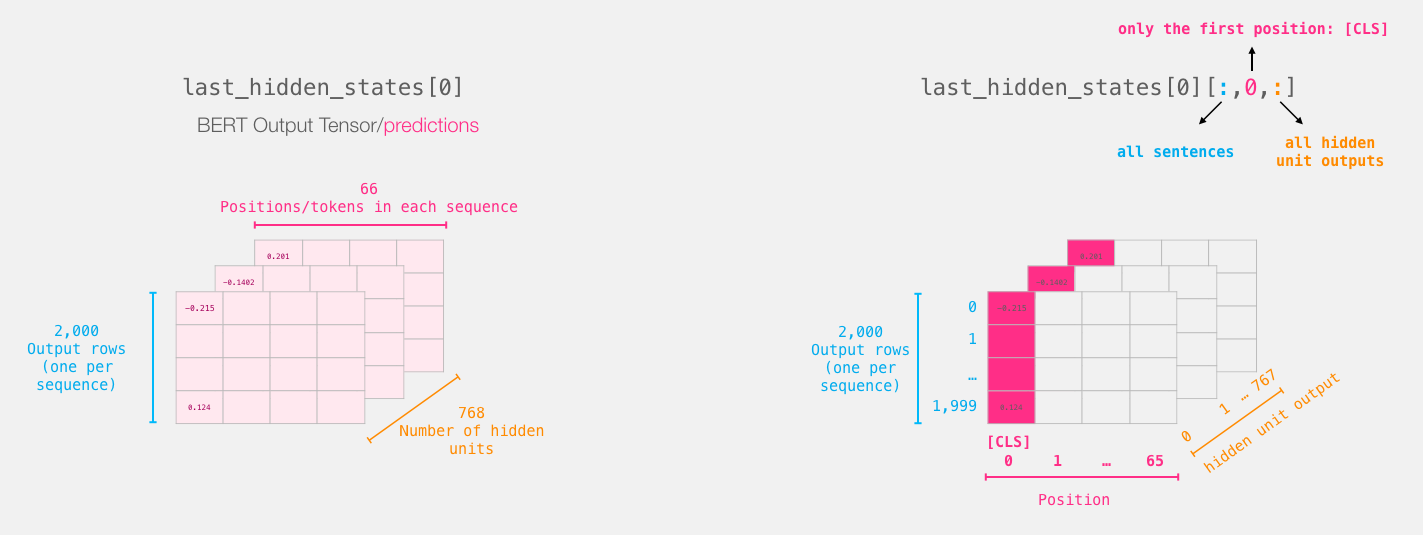

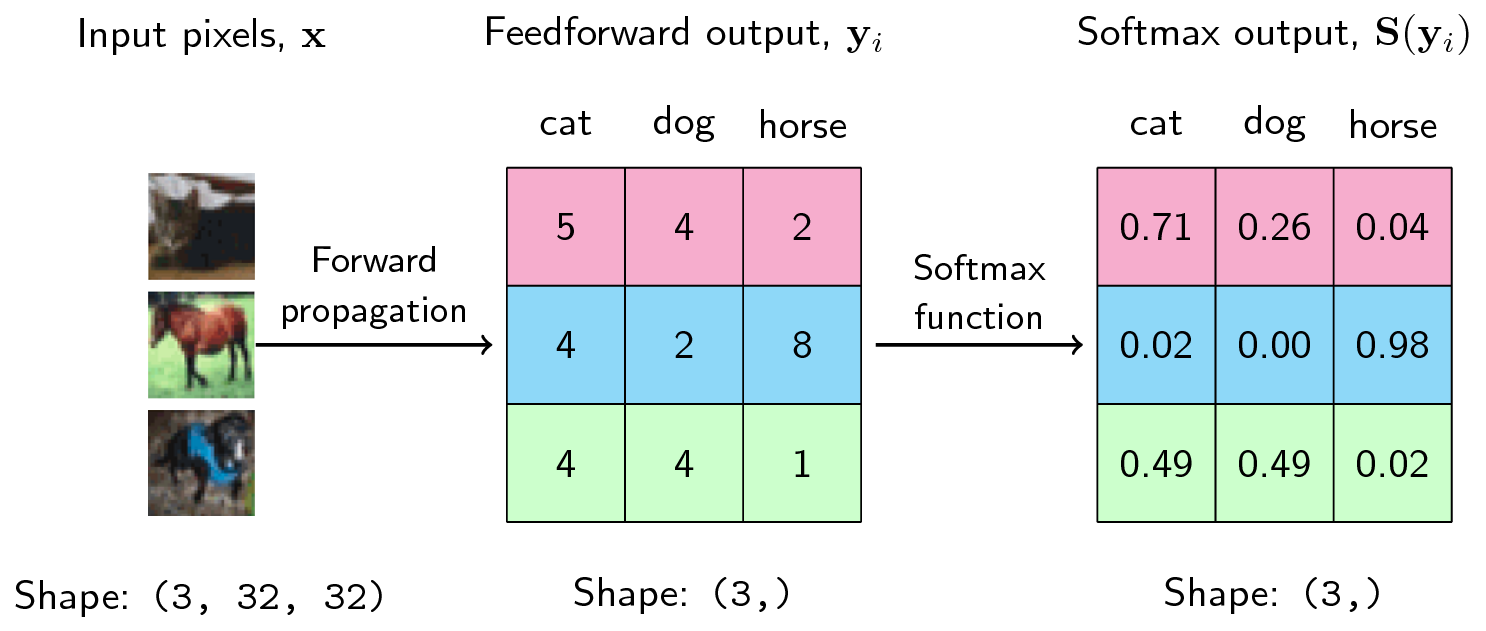

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 3
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8   
                      )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 80 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")


def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [ ]:
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   80    |   0.485662   |     -      |     -     |   41.49  
   1    |   160   |   0.287048   |     -      |     -     |   43.23  
   1    |   240   |   0.289128   |     -      |     -     |   46.28  
   1    |   320   |   0.269090   |     -      |     -     |   46.18  
   1    |   400   |   0.261517   |     -      |     -     |   46.39  
   1    |   480   |   0.263743   |     -      |     -     |   46.28  
   1    |   560   |   0.257473   |     -      |     -     |   46.35  
   1    |   640   |   0.247393   |     -      |     -     |   46.36  
   1    |   696   |   0.273046   |     -      |     -     |   32.43  
----------------------------------------------------------------------
   1    |    -    |   0.293631   |  0.248322  |   90.74   |  410.82  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   80 

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()
    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return probs

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)
from sklearn.metrics import accuracy_score

ypred = []
for i in probs:
  ypred.append(i.argmax())

accuracy_score(y_val, ypred)

0.9124647035094796

In [ ]:
#importing the test dataset
df2 = pd.read_csv('https://query.data.world/s/5zp7kqkhp6aycvezneyvw4s5vncwyp')

#filtering
print("Test dataset before filtering: ")
print(df2.head())
print("-"*80)
df2.rename(columns = {'Unnamed: 0':'id'}, inplace = True) 
df2.rename(columns = {'Lyrics':'text'}, inplace = True)
test=df2[['id','text']]
print("Test dataset after filtering: ")
print(test.head())
print("-"*80)

Test dataset before filtering: 
       WeekID  ...  Sentiment
0  1958-08-02  ...   0.500000
1  1958-08-02  ...   0.000000
2  1958-08-02  ...   0.028175
3  1958-08-02  ...  -0.089815
4  1958-08-02  ...   0.278788

[5 rows x 13 columns]
--------------------------------------------------------------------------------
Test dataset after filtering: 
      id                                               text
0   7969  For your love, oh, I would do anything\nI woul...
1   1176  Do you want to dance and hold my hand?\nTell m...
2   7536  Well...\n\nYou're gonna miss me\nEarly in the ...
3   7028  VERSE 1\nThe night was black, rain falling dow...
4  27738  You need hands\nTo hold someone you care for\n...
--------------------------------------------------------------------------------


In [ ]:
# Run `preprocessing_for_bert` on the test set
test_inputs, test_masks = preprocessing_for_bert(df2.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

KeyboardInterrupt: ignored

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
ypred = []
for i in probs:
  ypred.append(i.argmax())

In [ ]:
ypred = pd.Index(ypred)
ypred.value_counts()